In [107]:
import gym 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU 
import torch.nn.functional as F
from torch.autograd import Variable

This notebook use a vanilla Actor Critic Algorithm which is the exactly the same one on 
page 332, Reinforcement Learning by Sutton 2018 Edition. 

Thus, it is not A2C which uses Advantage and not Q-based method. It does not use Eligibility Trace as well.
Nevertheless, it is able to converge to stable optimal policy within around 1000 episodes.

In [171]:
class Actor(torch.nn.Module):
    def __init__(self):
        super(Actor,self).__init__()
        self.fc1 = Linear(4, 64)
        self.fc2 = Linear(64, 48)
        self.fc3 = Linear(48, 2)
        self.fc4 = Linear(48, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action = F.log_softmax(self.fc3(x), dim=-1)
        V = F.relu(self.fc4(x))
        return action, V

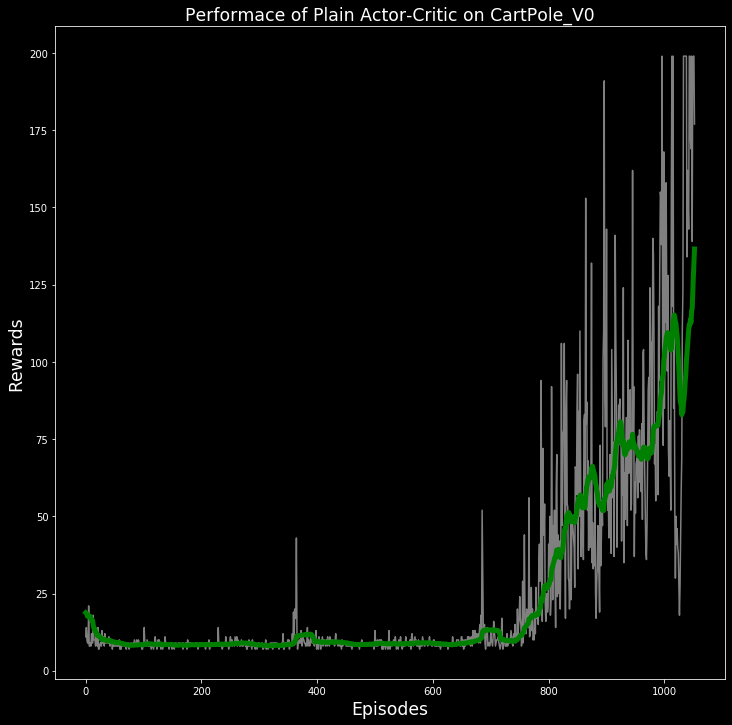

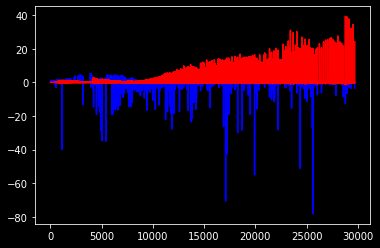

In [172]:
env = gym.make('CartPole-v0')
obs = env.reset()
actor = Actor()
optimizer_actor= torch.optim.Adam(actor.parameters(), lr=0.0003)
gamma = 0.99
alpha_c = 0.01
steps = []
A_loss = []
C_loss = []
for episode in range(2000):
    I = 1
    for step in range(200):
        # obs_list.append(obs)
        obs = np.reshape(obs, [1,-1])
        input_actor = Variable(torch.from_numpy(obs).float())
        action_probability, V = actor(input_actor)
        p = np.exp(action_probability[0].detach())
        action = np.random.choice(2, p=p.numpy())     
        obs, reward, done, info = env.step(action)
        
        obs = np.reshape(obs, [1,-1])
        next_input_actor = Variable(torch.from_numpy(obs).float())
        _, next_V = actor(next_input_actor)
        if done:
            delta = reward - V
        else:
            delta = gamma*next_V.detach() + reward - V
        Actor_Loss = - action_probability[0][action]*delta.detach()*I
        A_loss.append(Actor_Loss)
        target = gamma*next_V.detach() + reward
        Critic_Loss = -alpha_c*delta.detach()*V
        C_loss.append(Critic_Loss)
        I = gamma*I
        loss = Actor_Loss + Critic_Loss
        actor.zero_grad()
        loss.backward()
        optimizer_actor.step()
        if done:
            steps.append(step)
            print(f'episode {episode}, step {step}', end='\r')
            obs = env.reset()
            break
    if np.mean(steps[-20:]) > 180:
        break   
mid = []
interval = 30
plt.style.use('dark_background')
for i in range(len(steps) - interval):
    mid.append(np.mean(steps[i:i+interval+1]))
plt.figure(figsize=(12,12))
plt.title('Performace of Plain Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Rewards',fontsize = 'xx-large')
x_fit = list(range(len(steps) - interval))
plt.plot(x_fit, steps[interval:], '-', c = 'gray') 
plt.plot(mid, '-', c= 'green', linewidth = 5)
plt.show()
plt.plot(A_loss, c = 'blue')
plt.plot(C_loss, c = 'red')
plt.show()
